In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy import stats

# the splitting routines
# import splitting as s

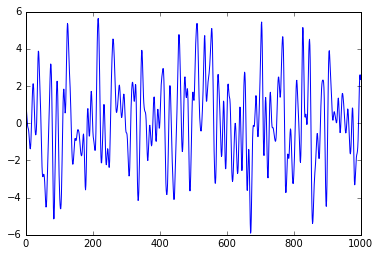

In [2]:
bias = 0
amplitude = 1
length = 1000
gauss1 = np.random.normal(bias,amplitude,length)
gauss2 = np.random.normal(bias,amplitude,length)

width = 3
smooth = signal.gaussian(length,width)

noise1 = np.convolve(gauss1, smooth,'same')
noise2 = np.convolve(gauss2, smooth,'same')
# plt.plot(gauss1)
plt.plot(noise1)
# plt.plot(smooth)

In [3]:
# calculate energy on noise1
E = np.sum(noise1**2)

# or using parsevals theorem
G1 = np.fft.fft(gauss1)
S1 = np.fft.fft(smooth)
S1 = np.pad(S1,(0,G1.size - S1.size),'constant')
# check convolution is the same as multiplication in Fourier domain
checkconv = np.real(np.fft.ifft(G1*S1))


G1.size
S1.size
# print(E)

1000

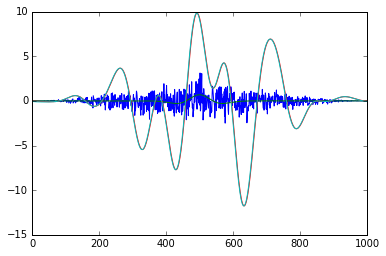

In [4]:
# check that convolution is the same as multiplication in the Fourier domain

a = np.random.normal(0,1,1000) * np.hanning(1000)
b = signal.ricker(1000,40)*5 * np.hanning(1000)
c = np.convolve(a,b,'same')
plt.plot(a)
plt.plot(b)
plt.plot(c)
A = np.fft.fft(a)
B = np.fft.fft(b)
C = np.roll(np.fft.ifft(A*B),500)
plt.plot(np.real(C))

# result:
# it is but you need to "roll" the answer by half the trace 
# length and use a taper to remove edge artefacts

In [5]:
# check Parseval's theorem holds numerically 
nsamps=1000
a = np.random.normal(0,1,nsamps) * signal.tukey(nsamps,0.05)
# b = signal.ricker(nsamps,40)*5 * signal.tukey(nsamps,.5)
# a = np.random.normal(0,1,nsamps) 
# b = signal.ricker(nsamps,40)*5 
# c = np.convolve(a,b,'same')
e = np.sum(a**2)

A = np.fft.fft(a)
# B = np.fft.fft(b)
C = np.absolute(A)
# multiply first and last samps by 0.5 before sum
# Ccoeff = np.ones(A.size)
E = np.sum(C**2)/C.size

print('time domain',e)
print('fourier domain',E)
print('difference',np.abs(e-E))
print('percent', (np.abs(e-E)/e)*100)

# conclusion yes it holds pretty well but don't 
# need to multiply first and last samps by 0.5
# as suggested in Walsh paper and do need to divide by number of samples
# to equalise results

# note the similarity in the form i prefer to the wiki


time domain 925.78949503
fourier domain 925.78949503
difference 1.13686837722e-13
percent 1.22799878733e-14


Parsevals theorem when applied to discrete Fourier Transform looks like this.

$\sum _{n=0}^{N-1}|x[n]|^{2}={\frac {1}{N}}\sum _{k=0}^{N-1}|X[k]|^{2}$

Source: https://en.wikipedia.org/wiki/Parseval%27s_theorem

(array([  2.00000000e+00,   6.10000000e+01,   4.02000000e+02,
          1.40800000e+03,   2.65000000e+03,   2.83900000e+03,
          1.87000000e+03,   6.18000000e+02,   1.30000000e+02,
          2.00000000e+01]),
 array([-3.98673538, -3.21480247, -2.44286955, -1.67093664, -0.89900372,
        -0.12707081,  0.64486211,  1.41679502,  2.18872794,  2.96066085,
         3.73259377]),
 <a list of 10 Patch objects>)

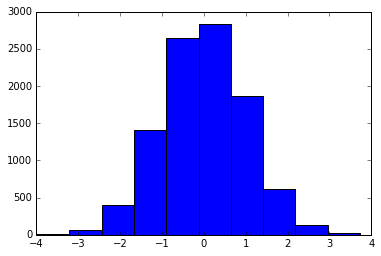

In [6]:
# histogram of noise -- is it gaussian? (should be it's synthetic!)
plt.hist(np.random.normal(0,1,10000))

In [7]:
def ndf(y,taper=True,detrend=True):
    """
    Uses the improvement found by Walsh et al (2013).
    By default will detrend data to ensure zero mean
    and will taper edges using a Tukey filter affecting amplitudes of 5% of data at edges
    """

    if taper is True:
        y = y * signal.tukey(y.size,0.05)
        
    if detrend is True:
        # ensure no trend on the noise trace
        y = signal.detrend(y)

  
    Y = np.fft.fft(y)
    amp = np.absolute(Y)
    
    # estimate E2 and E4 following Walsh et al (2013)
    a = np.ones(Y.size)
    a[0] = a[-1] = 0.5
    E2 = np.sum( a * amp**2)
    E4 = (np.sum( (4 * a**2 / 3) * amp**4))
    
    ndf = 2 * ( 2 * E2**2 / E4 - 1 )
    
    return ndf
    
def ndf2(y,taper=True,detrend=True):
    """
    
    """

    if taper is True:
        y = y * signal.tukey(y.size,0.05)
        
    if detrend is True:
        # ensure no trend on the noise trace
        y = signal.detrend(y)

  
    Y = np.fft.fft(y)
    amp = np.absolute(Y)
    
    E2 = np.sum(amp**2)/amp.size
    E4 = (np.sum( (4/3) * amp**4))/amp.size
    
    ndf = 2 * ( 2 * E2**2 / E4 - 1 )
    
    return ndf

In [8]:
# ndf(gauss1,taper=True,detrend=False)
y = np.interp(np.arange(gauss1.size*2),2*np.arange(gauss1.size),gauss1)
# print(ndf(gauss1,taper=True,detrend=True))
# print(ndf(gauss1,taper=True))
# print(ndf(gauss1,detrend=True))
print(ndf(noise1))
print(ndf(noise1,taper=True))

print(ndf2(noise1))

229.973630804
229.973630804
-1.7671087846


/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


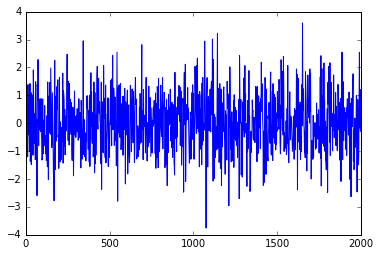

In [9]:
plt.plot(y)

In [10]:

E2 = (np.sum(C**2))
E4 = (np.sum(4/3*C**4))
e2 = E2/1000
e4 = E4/1000

def v(E2,E4):
    return 2 * ((2*E2**2/E4)-1)

print(v(E2,E4))
print(v(e2,e4))


1561.4759049
-0.436524095099


In [11]:
nsamps=1000
width=3
f = signal.gaussian(nsamps,width)
g = np.random.normal(0,1,nsamps)
n = np.convolve(f,g,'same')
F = np.fft.fft(f)
G = np.fft.fft(g)
N = np.fft.fft(n)

In [12]:
E = np.sum(F**2 * G**2) / nsamps

In [13]:
E
np.sum(n**2)

4049.5377023500992

In [14]:
d = s.Pair()
d.split(-30,8)

NameError: name 's' is not defined

In [ ]:
d.plot()

In [ ]:
np.cov(d,rowvar=True)

In [ ]:
vals,vecs = np.linalg.eig(np.cov(d.data))

In [ ]:
vecs

In [ ]:
M = d.grideigval()


In [ ]:
np.unravel_index(M.lam1.argmin(),M.lam2.shape)

In [ ]:
def plot_surf(lags,degs,vals,cmap='viridis'):
    plt.contourf(lags,degs,vals,cmap=cmap)
    plt.show()

In [ ]:
d = s.Pair()
d.split(45,14)
M = d.grideigval()
plot_surf(M.lags,M.degs,M.lam1/M.lam2,cmap='viridis')

In [ ]:
plot_surf(M.lags,M.degs,M.lam1/M.lam2)


In [ ]:
(M.lam1/M.lam2)[2,:]

In [ ]:
plot_surf(M.lags,M.degs,R(M,30),cmap='viridis_r')

In [ ]:
def Ftest(M,ndf,alpha=0.05):
    """
    returns lambda2 value at 100(1-alpha)% confidence interval
    by default alpha=0.05 yielding the value of lambda2 at 95% confidence interval
    """
    lam2min = M.lam2.min()
    k = 2
    R = ((M.lam2 - lam2min)/k) /  (lam2min/(ndf-k))
    F = stats.f.ppf(1-alpha,k,ndf)
    lam2alpha = lam2min * ( 1 + (k/(ndf-k)) * F)
    return lam2alpha

    

In [ ]:
plt.contourf(M.lags,M.degs,M.lam1/M.lam2,cmap='viridis')
plt.contour(M.lags,M.degs,M.lam2,levels=[Ftest(M,5,alpha=0.05)])
plt.show()

In [ ]:
Ftest2(M,4,alpha=0.05)

In [ ]:
(M.lam1/M.lam2).max()

In [ ]:

plt.plot(np.cosh(np.arange(100)))